In [13]:
pip install tensorflow tensorflow gpu pandas matplotlib sklearn

ERROR: Could not find a version that satisfies the requirement gpu (from versions: none)
ERROR: No matching distribution found for gpu


In [14]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [15]:
df = pd.read_csv(os.path.join("train.csv"))

FileNotFoundError: ignored

In [ ]:
df.head()

In [ ]:
df.iloc[0]['comment_text']

In [ ]:
df[df.columns[2:]].iloc[3]

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
df.columns

In [ ]:
df[df.columns[2:]].values

In [ ]:
MAX_FEATURES = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length = 1800,
                               output_mode = 'int')

In [ ]:
vectorizer.adapt(x.values)

In [ ]:
vectorizer.get_vocabulary()

In [ ]:
vectorizer_text = vectorizer(x.values)

In [ ]:
vectorizer_text

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizer_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)


In [ ]:
batch_x, batch_y=dataset.as_numpy_iterator().next()

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train_gen = train.as_numpy_iterator()

In [ ]:
train_gen.next()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [16]:
model.summary()

NameError: ignored

In [ ]:
history = model.fit(train,epochs=10, validation_data=val)

In [36]:
history.history

{'loss': [0.062102850526571274], 'val_loss': [0.05190494656562805]}

In [38]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

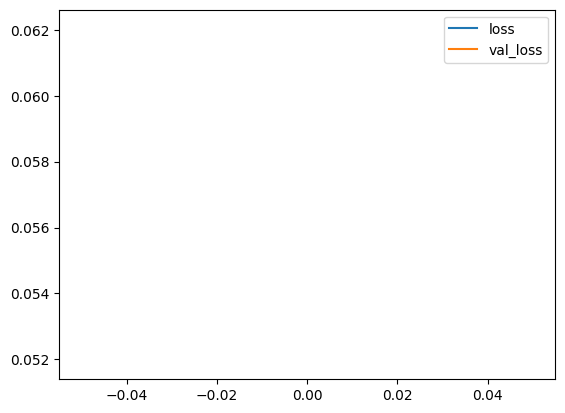

In [39]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [51]:
input_text = vectorizer('You freaking suck!')

In [53]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [55]:
batch = test.as_numpy_iterator().next()

In [57]:
batch_x, batch_y = test.as_numpy_iterator().next()

In [59]:
(model.predict(batch_x)>0.5).astype(int)

1/1 [==============================] - 0s 63ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [50]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 51ms/step


array([[0.9699934 , 0.16139027, 0.86895895, 0.03433238, 0.6784361 ,
        0.12245312]], dtype=float32)

In [48]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 51ms/step


In [61]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [62]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [63]:
for batch in test.as_numpy_iterator():
  x_true, y_true = batch
  yhat = model.predict(x_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 59ms/step


In [64]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8376944661140442, Recall:0.6772441267967224, Accuracy:0.4613841474056244


In [9]:
!pip install gradio jinja2


In [5]:
!pip install kaleido


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.3 MB/s eta 0:00:00


In [10]:
import gradio as gr

ImportError: ignored

In [12]:
model.save('Comment_toxicity.h5')

NameError: ignored

In [11]:
model = tf.keras.models.load_model('Comment_toxicity.h5')

OSError: ignored

In [ ]:
input_str = vectorizer(' hey i freaking hate you!')

In [ ]:
res  = model.predict(np.expand_dims(input_str,0))

In [ ]:
res

In [ ]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumeric(df.columns[2:1]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

In [ ]:
interface = gr.Interface(fn = score_comment,
                         inputs = gr.inputs.Textbox(lines=2, placeholder = 'Comment to score'),
                         outputs='text')

In [ ]:
interface.launch(share=True)